# Second task
In this second task the goal is to identify the russet or at least some part of it in a daset of apple's images in order to correctly classify the two fruits. 

## Step 1 - Binarization
The initial step involves **binarizing the image** to separate the fruit from the background.  
The technique employed calculates the median value of the pixels in the image, which is then divided by 2.   
Following the determination of the threshold, the image is converted to a binary format where pixels are set to either 0 or 255.  
This binary image effectively highlights the fruit by clearly differentiating it from the background.


![Binarization_1](./Second_task/results/Binarized_1.png)
![Binarization_2](./Second_task/results/Binarized_2.png)

## Step 2 - Segmentation
The subsequent step is to identify the largest connected component, corresponding to the fruit.  
This step is crucial for eliminating potential noise or spurious elements present in the binary image.  
By focusing on the largest connected component, the primary subject of interest in the image is isolated.  
The binary image is processed to fill any holes within the detected object, resulting in a solid mask of the fruit.  
Erosion is then applied to this mask to remove any dark contours outlining the fruit.


![Segmentation_1](./Second_task/results/Filled_1.png)
![Segmentation_2](./Second_task/results/Filled_2.png)

## Step 3 - Smoothing
The isolated fruit mask is used to extract the corresponding region from the original color image.  
A bilateral filter is applied to the extracted region to smooth the image while preserving edge details.  
This filtering step helps reduce noise and small irregularities in the image without blurring important features.  
The resulting smoothed image is more uniform, which makes subsequent analysis more reliable.  
The filtered image is then converted to **LAB** and **HSV** color spaces for further color-based analysis.
This comparison is done in order to check which one of the color space will give the best result.


## Step 4 - Find defect colour with samples in LAB and HSV color spaces
Sample images of known defects are used to calculate the mean and covariance of the color values in **LAB** and **HSV** spaces.  
These calculations provide a statistical representation of the defect colors, forming a ***reference*** for comparison.  
In the LAB space, the mean and covariance of the 'a' and 'b' channels are calculated, along with the mean 'L' value.  
    - The 'L' channel represents lightness, indicating the brightness of the color.  
    - The 'a' channel represents the green to red color spectrum, indicating the color balance between green and red.  
    - The 'b' channel represents the blue to yellow color spectrum, indicating the color balance between blue and yellow.  
In the HSV space, the mean and covariance of the 'S' and 'V' channels are calculated, along with the mean 'H' value.  
    - The 'H' channel represents the hue, indicating the type of color (such as red, green, or blue).  
    - The 'S' channel represents saturation, indicating the intensity or purity of the color.  
    - The 'V' channel represents value (brightness), indicating the brightness of the color.  
 
These reference values define the typical color characteristics of defects in both color spaces.

## Step 5 - Compute the Mahalanobis and Euclidean distances
To identify defects, the Mahalanobis distance in the LAB space and the Euclidean distance in the HSV space are computed.  
The Mahalanobis distance measures how closely the color of each pixel matches the reference defect color in the LAB space.  
Similarly, the Euclidean distance measures the color difference in the HSV space.  
Pixels with distances below certain thresholds are considered part of the defect.  
This dual-space analysis improves the accuracy of defect detection by exploiting the strengths of both color spaces.

## Step 6 - Defects Identification
Connected components labeling is performed on the detected defect areas.  
Each connected component is analyzed to identify individual defects within the fruit.  
Defects are then highlighted on the original image by drawing contours around them.  
This visual representation clearly identifies the extent and location of defects on the fruit.  
The number of detected defects is counted and reported for each image, providing a quantitative assessment of the fruit's condition.

## Conclusion
During the analysis, it was observed that the first image presented some challenges, including false positives.  
The detection algorithm identified areas that were incorrectly marked as defects.  
However, the results obtained in the LAB color space were generally more accurate compared to those in the HSV color space.  
The LAB space provided a better distinction of the defect colors, reducing the number of false positives and offering more reliable defect identification.  

# Code

In [29]:
import cv2
import numpy as np
from tools import array_of_images, get_threshold, fill_element, show_images, draw_fruit_outline, upload_samples, get_component, draw_defect
from scipy.spatial.distance import cdist, euclidean

In [30]:
image_path = "./Second_task/images"
gray_images, color_images = array_of_images(image_path)
sample_path = "./Second_task/images/defects"
samples = upload_samples(sample_path)

In the image 01 in the LAB space the system detected 3 defect(s)
In the image 01 in the HSV space the system detected 5 defect(s)
In the image 02 in the LAB space the system detected 1 defect(s)
In the image 02 in the HSV space the system detected 1 defect(s)


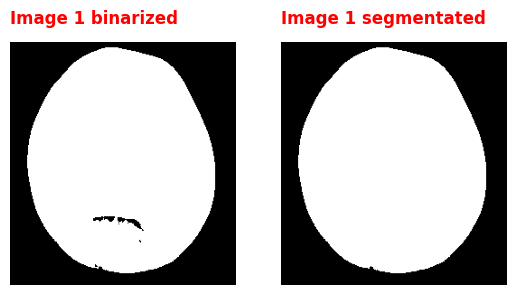

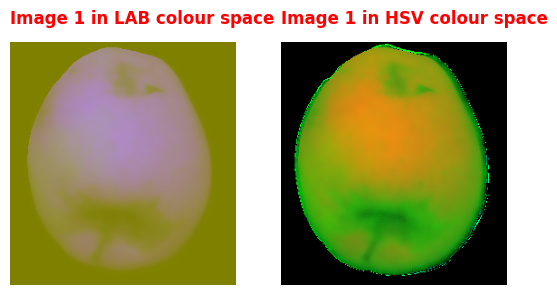

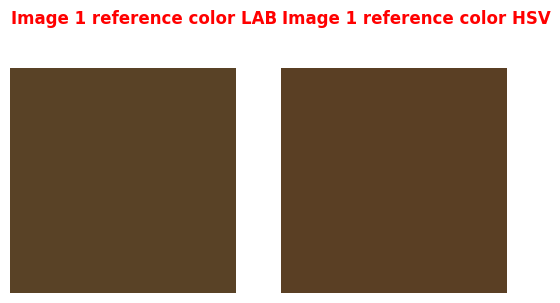

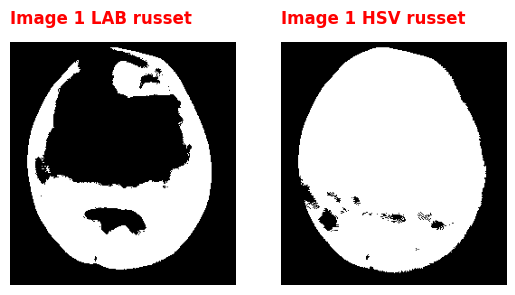

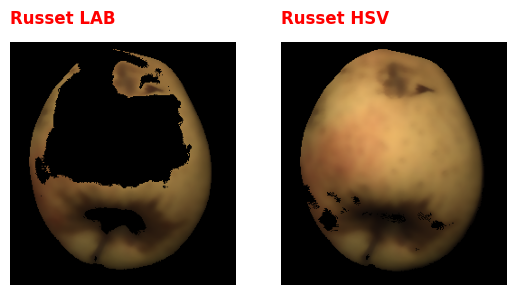

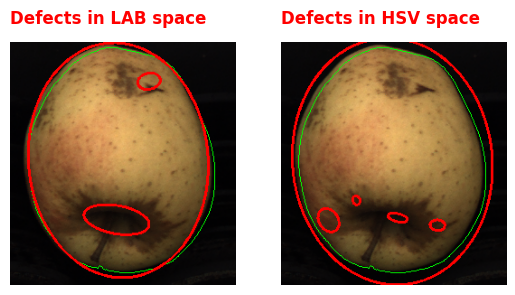

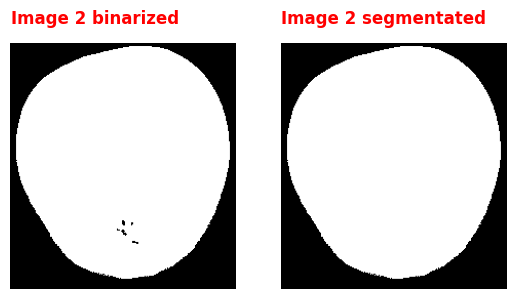

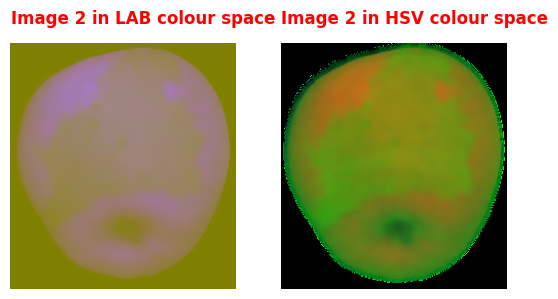

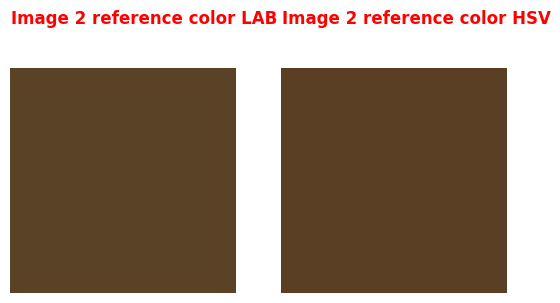

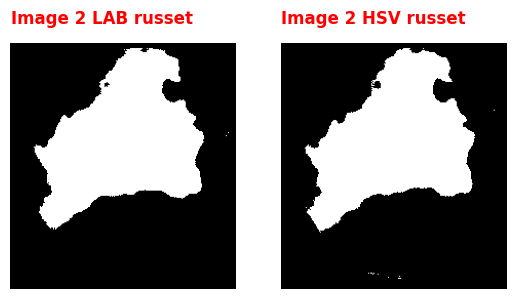

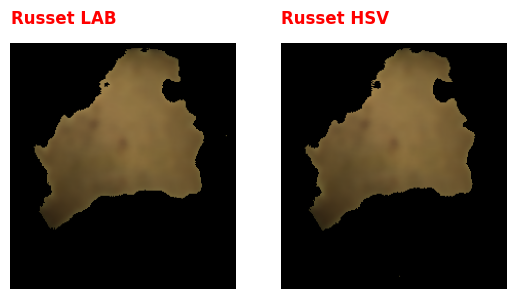

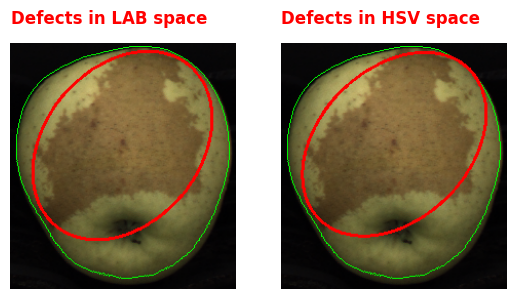

In [32]:
image_count = 1
for i in range(len(gray_images)):
    gray_image = gray_images[i]
    color_image = color_images[i]

    # Convert image to grayscale
    gray = cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)

    #STEP 1 - BINARIZATION
    # Calculate the adaptive threshold as  median / 2' 
    median = get_threshold(gray)

    # Binarize the image to separate foreground and background
    threshold, binarized = cv2.threshold(gray, median, 255, cv2.THRESH_BINARY)

    #Step 2 - SEGMENTATION
    # Find the fruit in the image as it is the biggest connencted component
    filled_image = fill_element(binarized)

    show_images("Image " + str(image_count) + " binarized", "Image " + str(image_count) + " segmentated", binarized, filled_image)

    # Erode one time to remove dark contour
    kernel = np.ones((5, 5), np.uint8)
    eroded = cv2.erode(filled_image, kernel, iterations=1)

    #Step 3 - SMOOTHING
    # Get grayscale fruit from filled mask
    mask = cv2.bitwise_and(color_image, color_image, mask=filled_image)
    #Blurred image with the bilateral filter, that is an edge-preserving filter
    blurred_image = cv2.bilateralFilter(mask, 11, 100, 75)

    fruit = cv2.bitwise_and(blurred_image, blurred_image, mask=eroded)
    # Convert isolated fruit to LAB color space 
    fruit_lab = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2LAB)

    # Convert isolated fruit to HSV color space 
    fruit_hsv = cv2.cvtColor(blurred_image, cv2.COLOR_BGR2HSV)

    show_images("Image " + str(image_count) + " in LAB colour space", "Image " + str(image_count) + " in HSV colour space", fruit_lab, fruit_hsv)

    #Step 4 - FIND DEFECT COLOUR WITH SAMPLES in LAB and HSV color spaces
    # Create data structures to store total covariance and mean of samples
    covariance_tot_LAB = np.zeros((2, 2), dtype="float64")
    covariance_tot_HSV = np.zeros((2, 2), dtype="float64")
    mean_tot_LAB = np.zeros((1, 2), dtype="float64")
    mean_tot_HSV = np.zeros((1, 2), dtype="float64")

    L_tot = 0
    H_tot = 0
    
    # Example in the LAB space
    for s in samples:
        s_lab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)
        s_l = s_lab[:, :, 0]  
        s_ab = s_lab[:, :, 1:3]
        s_ab_r = s_ab.reshape(s_ab.shape[0] * s_ab.shape[1], 2)
        cov_LAB, mean_LAB = cv2.calcCovarMatrix(s_ab_r, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
        covariance_tot_LAB = np.add(covariance_tot_LAB, cov_LAB)
        mean_tot_LAB = np.add(mean_tot_LAB, mean_LAB)
        L_tot += np.mean(s_l)

    # Compute the mean of the means of all the samples to find the reference color
    russet_sample_lab = mean_tot_LAB / len(samples)
    L_value = L_tot / len(samples)

    # Add the L value of the brightness to complete the LAB color
    russet_sample_LAB = np.array([[L_value, russet_sample_lab[0][0], russet_sample_lab[0][1]]], dtype="float64")

    # Convert the LAB color in RGB
    russet_sample_LABtoBGR = cv2.cvtColor(russet_sample_LAB.astype("uint8").reshape(1, 1, 3), cv2.COLOR_LAB2BGR).reshape(3)

    #Create an image with the found reference color
    reference_LAB = np.full((100, 100, 3), russet_sample_LABtoBGR, dtype="uint8")

    # Example in the HSV space
    for s in samples:
        s_hsv = cv2.cvtColor(s, cv2.COLOR_BGR2HSV)
        s_h = s_hsv[:, :, 0]  
        s_sv = s_hsv[:, :, 1:3]
        s_sv_r = s_sv.reshape(s_sv.shape[0] * s_sv.shape[1], 2)
        mean_HSV = np.mean(s_sv_r, axis=0)
        mean_tot_HSV = np.add(mean_tot_HSV, mean_HSV)
        H_tot += np.mean(s_h)

    # Compute the mean of the means of all the samples to find the reference color
    russet_sample_hsv = mean_tot_HSV / len(samples)
    H_value = H_tot / len(samples)

    # Add the V value of the brightness to complete the HSV color
    russet_sample_HSV = np.array([[H_value, russet_sample_hsv[0][0], russet_sample_hsv[0][1]]], dtype="float64")

    # Convert the HSV color to BGR
    russet_sample_HSVtoBGR = cv2.cvtColor(russet_sample_HSV.astype("uint8").reshape(1, 1, 3), cv2.COLOR_HSV2BGR).reshape(3)

    # Create an image with the found reference color
    reference_HSV = np.full((100, 100, 3), russet_sample_HSVtoBGR, dtype="uint8")


    #Step 5 - COMPUTE THE MAHALANOBIS DISTANCE
    # Compute the inverse of the covariance matrix (needed to measure Mahalanobis distance)
    inv_cov_LAB = cv2.invert(covariance_tot_LAB, cv2.DECOMP_SVD)[1]
    #inv_cov_HSV = cv2.invert(covariance_tot_HSV, cv2.DECOMP_SVD)[1]

    russet_component_LAB = np.zeros_like(binarized)
    russet_component_HSV = np.zeros_like(binarized)
    
    # Compute pixel-wise Mahalanobis distance between fruit and reference color in LAB space
    for r in range(fruit_lab.shape[0]):
        for c in range(fruit_lab.shape[1]):
            if filled_image[r][c]:
                p_lab = np.array(fruit_lab[r][c])[1:3].reshape(1, 2)
                # Mahalanobis distance
                dist_lab = cdist(p_lab, russet_sample_lab, 'mahalanobis', VI=inv_cov_LAB)

                # Checking if the distance is small, than p is part of the russet
                if dist_lab < 1.5:
                    # Store russet's pixel location
                    russet_component_LAB[r][c] = 255

    # Compute pixel-wise Euclidean distance between fruit and reference color in HSV space
    for r in range(fruit_hsv.shape[0]):
        for c in range(fruit_hsv.shape[1]):
            if filled_image[r][c]:
                p_hsv = fruit_hsv[r][c][0:2]
                ref_hsv = russet_sample_HSV[:,0:2].flatten()

                # Euclidean distance
                dist_hsv = euclidean(p_hsv, ref_hsv)
                # Checking if the distance is small, than p is part of the russet
                if dist_hsv < 20:
                    # Store russet's pixel location
                    russet_component_HSV[r][c] = 255

    show_images("Image " + str(image_count) + " reference color LAB", "Image " + str(image_count) + " reference color HSV", reference_LAB, reference_HSV)
    show_images("Image " + str(image_count) + " LAB russet", "Image " + str(image_count) + " HSV russet", russet_component_LAB, russet_component_HSV)

    #Step 6 - DEFECTS IDENTIFICATION 
    # Perform a connected components labeling of the russet
    retval_lab, labels_lab, stats_lab, centroids_lab = cv2.connectedComponentsWithStats(russet_component_LAB, 4)
    retval_hsv, labels_hsv, stats_hsv, centroids_hsv = cv2.connectedComponentsWithStats(russet_component_HSV, 4)
    original_lab = color_image.copy()
    original_hsv = color_image.copy()

    # Outline the fruit using the binary mask
    draw_fruit_outline(original_lab, filled_image, 1)
    draw_fruit_outline(original_hsv, filled_image, 1)

    #Identification of the defects by isolating them when iterating over the detected components
    defects_counter_LAB = 0
    for j in range(1, retval_lab):
        component_lab = get_component(labels_lab, j)
        defects_counter_LAB += draw_defect(original_lab, component_lab, 2, 1.1, 35, float("inf"), 5)

    russet_lab = cv2.bitwise_and(fruit, fruit, mask=russet_component_LAB)
        
    defects_counter_HSV = 0
    for j in range(1, retval_hsv):
        component_hsv = get_component(labels_hsv, j)
        defects_counter_HSV += draw_defect(original_hsv, component_hsv, 2, 1.1, 35, float("inf"), 5)

    russet_hsv = cv2.bitwise_and(fruit, fruit, mask=russet_component_HSV)

    show_images("Russet LAB", "Russet HSV", russet_lab, russet_hsv)
    show_images("Defects in LAB space", "Defects in HSV space", original_lab, original_hsv)

    #RECAP
    print("In the image 0" + str(image_count) + " in the LAB space the system detected " + str(defects_counter_LAB) + " defect(s)")
    print("In the image 0" + str(image_count) + " in the HSV space the system detected " + str(defects_counter_HSV) + " defect(s)")
    image_count += 1
